In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import math
import pickle
from torchsummary import summary
from math import ceil
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#vital params



dataset_name="cifar10"
 
model_name="EfficientNetb2_stn1"
version = "b2"

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

phi, res, drop_rate = phi_values[version]
#hyperparameters
batch_size=10
num_classes=-1
learning_rate=0.001
image_size=(res,res)

if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10


print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)
print("The input image size is:{}".format(image_size))

Model: EfficientNetb2_stn1 with 10 classes running on: cifar10
The input image size is:(260, 260)


In [2]:
# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    print(head_train_set.class_to_idx)
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)
    





print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))


print(train_set[0][0].shape)
print("Datasets loaded and prepared")

Files already downloaded and verified
Files already downloaded and verified
Dataset size: Train: 40000, Valid: 10000, Test: 10000
torch.Size([3, 260, 260])
Datasets loaded and prepared


In [3]:

class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.localization = nn.Sequential(
            #nn.Conv2d(3, 8, kernel_size=7),
            nn.Conv2d(3,8,kernel_size=3),
            nn.Conv2d(8,8,kernel_size=3),
            nn.Conv2d(8,8,kernel_size=3),
            
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            
            
            #nn.Conv2d(8, 10, kernel_size=5),
            nn.Conv2d(8,10, kernel_size = 3),
            nn.Conv2d(10,10,kernel_size = 3),
            
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(37210, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )
        


        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):

        xs = self.localization(x)
        xs = xs.view(-1, 10 * 61 * 61)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        
    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        self.stn(x)
        x = self.pool(self.features(x))
        
        return self.classifier(x.view(x.shape[0], -1))


def test():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    version = "b2"
    phi, res, drop_rate = phi_values[version]
    num_examples = 4
    x = torch.randn((num_examples, 3, res, res)).to(device)
    model = EfficientNet(
        version=version,
        num_classes=num_classes,
    ).to(device)
    print(x.shape)
    print(model(x).shape) # (num_examples, num_classes)

test()

#print("Efficient Net model defined")

torch.Size([4, 3, 260, 260])
torch.Size([4, 10])


C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [4]:
model = EfficientNet(
    version=version,
    num_classes=num_classes,
).to(device)

model = model.to(device)

from thop import profile
import colorama
from colorama import Fore,Style
#vital params
def getGFLOPS(test_model):
    model=test_model.to(device)
    input = torch.randn(1, 3, res, res).to(device)
    macs, params = profile(model, inputs=(input, ))

    print(Fore.BLUE + "The model requires: {:.4f} GFLOPS".format(macs/1000_000_000))
    print(Style.RESET_ALL)
    return macs
getGFLOPS(model)
#pretesting model for shape
x=torch.randn(batch_size,3,res,res)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print(summary(model, input_size=(3, res, res)))
print("model shape ready")

#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

print("model initialised")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.SiLU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CNNBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Sigmoid'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.SqueezeExcitation'>. Treat it as zero 

C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


     BatchNorm2d-269          [-1, 744, 17, 17]           1,488
            SiLU-270          [-1, 744, 17, 17]               0
        CNNBlock-271          [-1, 744, 17, 17]               0
AdaptiveAvgPool2d-272            [-1, 744, 1, 1]               0
          Conv2d-273             [-1, 31, 1, 1]          23,095
            SiLU-274             [-1, 31, 1, 1]               0
          Conv2d-275            [-1, 744, 1, 1]          23,808
         Sigmoid-276            [-1, 744, 1, 1]               0
SqueezeExcitation-277          [-1, 744, 17, 17]               0
          Conv2d-278          [-1, 124, 17, 17]          92,256
     BatchNorm2d-279          [-1, 124, 17, 17]             248
InvertedResidualBlock-280          [-1, 124, 17, 17]               0
          Conv2d-281          [-1, 744, 17, 17]         830,304
     BatchNorm2d-282          [-1, 744, 17, 17]           1,488
            SiLU-283          [-1, 744, 17, 17]               0
        CNNBlock-284          [-1

In [5]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [6]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string:")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs/EfficientNetb2_stn120211123153541
grandstore_string:
grandstore/cifar10_EfficientNetb2_stn120211123153541.pkl


In [7]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [8]:
TOP_ACCURACY_TRACK = 10
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=330,
                    minepoch=150,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                 
                   )

Running epoch: 1


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 41.260
Training Loss: 161177962.1467 	Validation Loss: 15502.8823

Running epoch: 2


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 59.910
Training Loss: 124738485.3664 	Validation Loss: 11265.8020

Running epoch: 3


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 64.330
Training Loss: 94165506.4457 	Validation Loss: 9964.7596

Running epoch: 4


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 72.420
Training Loss: 76916927.6965 	Validation Loss: 7819.5677

Running epoch: 5


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 77.030
Training Loss: 64791484.3317 	Validation Loss: 6633.3542

Running epoch: 6


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 78.530
Training Loss: 55626979.0197 	Validation Loss: 6302.9850

Running epoch: 7


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 81.100
Training Loss: 49211527.5519 	Validation Loss: 5521.2031

Running epoch: 8


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 81.910
Training Loss: 43696671.7629 	Validation Loss: 5225.1017

Running epoch: 9


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 81.530
Training Loss: 38686354.5329 	Validation Loss: 5419.4200

Running epoch: 10


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 83.630
Training Loss: 34432276.9787 	Validation Loss: 4782.6459

Running epoch: 11


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 83.080
Training Loss: 30633093.0775 	Validation Loss: 5055.9212

Running epoch: 12


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.750
Training Loss: 27192616.5627 	Validation Loss: 4758.9516

Running epoch: 13


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.050
Training Loss: 24290309.0852 	Validation Loss: 4640.7288

Running epoch: 14


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.850
Training Loss: 21456268.5543 	Validation Loss: 4870.0612

Running epoch: 15


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.240
Training Loss: 18908277.0855 	Validation Loss: 4740.6423

Running epoch: 16


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.170
Training Loss: 17396639.4576 	Validation Loss: 5449.2839

Running epoch: 17


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.030
Training Loss: 15398384.3069 	Validation Loss: 5274.0382

Running epoch: 18


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.010
Training Loss: 13620424.6356 	Validation Loss: 5227.6637

Running epoch: 19


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.180
Training Loss: 12588423.9991 	Validation Loss: 5666.9785

Running epoch: 20


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.800
Training Loss: 11899232.5355 	Validation Loss: 5595.6012

Running epoch: 21


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.890
Training Loss: 10324372.3339 	Validation Loss: 5921.6719

Running epoch: 22


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.280
Training Loss: 10116074.7465 	Validation Loss: 5479.4507

Running epoch: 23


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.110
Training Loss: 9577596.4164 	Validation Loss: 5301.7271

Running epoch: 24


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.010
Training Loss: 9233713.0609 	Validation Loss: 5264.6720

Running epoch: 25


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.450
Training Loss: 8490107.9872 	Validation Loss: 6026.6395

Running epoch: 26


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.490
Training Loss: 8007279.5892 	Validation Loss: 6041.0270

Running epoch: 27


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.780
Training Loss: 7808291.2797 	Validation Loss: 6843.1150

Running epoch: 28


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.380
Training Loss: 7428305.9251 	Validation Loss: 6038.0302

Running epoch: 29


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.550
Training Loss: 6826502.2364 	Validation Loss: 6377.8522

Running epoch: 30


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.350
Training Loss: 6686265.0317 	Validation Loss: 6604.8132

Running epoch: 31


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.660
Training Loss: 6237693.1464 	Validation Loss: 6305.8072

Running epoch: 32


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.400
Training Loss: 5946374.5750 	Validation Loss: 6496.5203

Running epoch: 33


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.070
Training Loss: 5820559.4612 	Validation Loss: 7007.5215

Running epoch: 34


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.190
Training Loss: 5834797.1530 	Validation Loss: 6102.3576

Running epoch: 35


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 84.640
Training Loss: 5628834.5700 	Validation Loss: 7531.8650

Running epoch: 36


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.030
Training Loss: 5497998.5158 	Validation Loss: 6444.2125

Running epoch: 37


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.400
Training Loss: 5397900.5805 	Validation Loss: 6965.5126

Running epoch: 38


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.360
Training Loss: 5391349.0811 	Validation Loss: 6875.7589

Running epoch: 39


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.090
Training Loss: 5114554.5931 	Validation Loss: 6721.0269

Running epoch: 40


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.820
Training Loss: 4884570.0561 	Validation Loss: 6856.0595

Running epoch: 41


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.230
Training Loss: 4823343.1853 	Validation Loss: 6571.7616

Running epoch: 42


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.620
Training Loss: 4523976.7950 	Validation Loss: 6998.2784

Running epoch: 43


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.330
Training Loss: 4410435.8647 	Validation Loss: 6728.1815

Running epoch: 44


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.210
Training Loss: 4273817.2893 	Validation Loss: 6479.1036

Running epoch: 45


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.640
Training Loss: 4028281.8835 	Validation Loss: 6971.1105

Running epoch: 46


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.550
Training Loss: 4093260.8421 	Validation Loss: 6783.9061

Running epoch: 47


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.310
Training Loss: 4106084.4432 	Validation Loss: 6720.2698

Running epoch: 48


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.140
Training Loss: 3868233.9484 	Validation Loss: 6973.6277

Running epoch: 49


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.190
Training Loss: 3628115.8139 	Validation Loss: 7160.8412

Running epoch: 50


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.780
Training Loss: 3756001.1942 	Validation Loss: 7003.6088

Running epoch: 51


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.070
Training Loss: 3501825.9840 	Validation Loss: 7229.5650

Running epoch: 52


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.130
Training Loss: 3815040.2865 	Validation Loss: 7425.3869

Running epoch: 53


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.260
Training Loss: 3325626.1966 	Validation Loss: 7268.6057

Running epoch: 54


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.600
Training Loss: 3686816.5148 	Validation Loss: 7201.2060

Running epoch: 55


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.830
Training Loss: 3417431.6134 	Validation Loss: 6822.6279

Running epoch: 56


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.510
Training Loss: 3280570.0456 	Validation Loss: 7498.2284

Running epoch: 57


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.010
Training Loss: 3311448.1320 	Validation Loss: 7114.6686

Running epoch: 58


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.760
Training Loss: 3054455.9635 	Validation Loss: 7886.2066

Running epoch: 59


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.340
Training Loss: 3411164.3907 	Validation Loss: 7192.5295

Running epoch: 60


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.260
Training Loss: 3213741.8265 	Validation Loss: 7501.8886

Running epoch: 61


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.030
Training Loss: 3200630.9140 	Validation Loss: 7616.6708

Running epoch: 62


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.860
Training Loss: 2845332.4608 	Validation Loss: 6945.7371

Running epoch: 63


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.570
Training Loss: 2895590.1017 	Validation Loss: 7693.7649

Running epoch: 64


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.450
Training Loss: 2703900.2599 	Validation Loss: 7618.3379

Running epoch: 65


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.940
Training Loss: 2890278.3125 	Validation Loss: 7487.4839

Running epoch: 66


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.970
Training Loss: 2783866.4163 	Validation Loss: 7308.8718

Running epoch: 67


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.230
Training Loss: 2890993.2137 	Validation Loss: 7215.6569

Running epoch: 68


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.320
Training Loss: 2637165.9718 	Validation Loss: 7700.3624

Running epoch: 69


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.460
Training Loss: 2910366.3253 	Validation Loss: 7842.6985

Running epoch: 70


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.740
Training Loss: 2632211.2310 	Validation Loss: 8218.6633

Running epoch: 71


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.590
Training Loss: 2691320.6325 	Validation Loss: 7784.6352

Running epoch: 72


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.200
Training Loss: 2517700.9094 	Validation Loss: 7480.4097

Running epoch: 73


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.750
Training Loss: 2513076.4048 	Validation Loss: 7671.8913

Running epoch: 74


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.540
Training Loss: 2559041.8568 	Validation Loss: 7491.3694

Running epoch: 75


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.260
Training Loss: 2205988.9941 	Validation Loss: 7524.6343

Running epoch: 76


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.270
Training Loss: 2537699.4992 	Validation Loss: 7813.7090

Running epoch: 77


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.510
Training Loss: 2421238.6844 	Validation Loss: 7206.9723

Running epoch: 78


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.220
Training Loss: 2344565.9806 	Validation Loss: 7699.9326

Running epoch: 79


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.080
Training Loss: 2424358.6643 	Validation Loss: 7857.8092

Running epoch: 80


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.220
Training Loss: 2320004.2159 	Validation Loss: 8107.3483

Running epoch: 81


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.350
Training Loss: 2327120.5407 	Validation Loss: 7861.0023

Running epoch: 82


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.710
Training Loss: 2434940.7074 	Validation Loss: 7590.0651

Running epoch: 83


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.820
Training Loss: 2233433.8209 	Validation Loss: 7061.5086

Running epoch: 84


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.950
Training Loss: 2273986.6748 	Validation Loss: 7951.2098

Running epoch: 85


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.930
Training Loss: 2265434.8327 	Validation Loss: 8464.1594

Running epoch: 86


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.330
Training Loss: 2166926.5288 	Validation Loss: 8016.1635

Running epoch: 87


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.360
Training Loss: 2186677.5940 	Validation Loss: 7809.9750

Running epoch: 88


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.730
Training Loss: 2342920.1508 	Validation Loss: 8675.0837

Running epoch: 89


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.460
Training Loss: 2253432.8266 	Validation Loss: 7989.0199

Running epoch: 90


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.450
Training Loss: 2239169.2869 	Validation Loss: 7862.2492

Running epoch: 91


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.970
Training Loss: 2094293.3121 	Validation Loss: 8508.9243

Running epoch: 92


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.820
Training Loss: 2032507.6008 	Validation Loss: 7924.7730

Running epoch: 93


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.450
Training Loss: 1889006.0553 	Validation Loss: 7895.6936

Running epoch: 94


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.050
Training Loss: 2232807.5652 	Validation Loss: 8009.4491

Running epoch: 95


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.130
Training Loss: 2107298.6708 	Validation Loss: 7594.6593

Running epoch: 96


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.730
Training Loss: 1930696.1103 	Validation Loss: 7867.0336

Running epoch: 97


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.420
Training Loss: 1913650.7160 	Validation Loss: 8589.4387

Running epoch: 98


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.670
Training Loss: 1946510.3112 	Validation Loss: 7988.5531

Running epoch: 99


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.280
Training Loss: 1828583.2697 	Validation Loss: 8267.2908

Running epoch: 100


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.960
Training Loss: 2301467.6081 	Validation Loss: 7544.7223

Running epoch: 101


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.170
Training Loss: 2032936.4039 	Validation Loss: 8724.9368

Running epoch: 102


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.410
Training Loss: 2567677.1050 	Validation Loss: 7894.5780

Running epoch: 103


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.830
Training Loss: 1860585.5108 	Validation Loss: 7501.3572

Running epoch: 104


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.600
Training Loss: 1615560.3796 	Validation Loss: 8134.5493

Running epoch: 105


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.710
Training Loss: 2062795.5450 	Validation Loss: 8338.2100

Running epoch: 106


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.820
Training Loss: 2003448.7742 	Validation Loss: 7528.1799

Running epoch: 107


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.860
Training Loss: 1768739.4014 	Validation Loss: 7809.6213

Running epoch: 108


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.410
Training Loss: 1737408.2366 	Validation Loss: 8049.4629

Running epoch: 109


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.040
Training Loss: 1763659.4620 	Validation Loss: 7755.8174

Running epoch: 110


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.040
Training Loss: 1814494.4617 	Validation Loss: 8730.9710

Running epoch: 111


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.090
Training Loss: 1820365.1392 	Validation Loss: 7976.8450

Running epoch: 112


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.820
Training Loss: 1863073.1749 	Validation Loss: 7954.3726

Running epoch: 113


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.700
Training Loss: 1647954.9098 	Validation Loss: 9052.7242

Running epoch: 114


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.230
Training Loss: 2168359.4835 	Validation Loss: 7864.0915

Running epoch: 115


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.550
Training Loss: 1580055.6226 	Validation Loss: 8065.0089

Running epoch: 116


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.660
Training Loss: 1484928.2379 	Validation Loss: 8335.3147

Running epoch: 117


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.840
Training Loss: 1891171.4458 	Validation Loss: 8041.6284

Running epoch: 118


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.510
Training Loss: 1603346.1540 	Validation Loss: 8535.5073

Running epoch: 119


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.550
Training Loss: 1796559.8203 	Validation Loss: 8534.3983

Running epoch: 120


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.860
Training Loss: 1769651.2231 	Validation Loss: 8281.6757

Running epoch: 121


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.690
Training Loss: 1617314.8954 	Validation Loss: 9315.4779

Running epoch: 122


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.670
Training Loss: 1496530.0130 	Validation Loss: 8824.5472

Running epoch: 123


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.660
Training Loss: 1740232.3986 	Validation Loss: 8705.8676

Running epoch: 124


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.450
Training Loss: 1629572.3858 	Validation Loss: 8536.6757

Running epoch: 125


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.850
Training Loss: 1484764.7492 	Validation Loss: 8018.0977

Running epoch: 126


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.440
Training Loss: 1796299.4921 	Validation Loss: 8869.5023

Running epoch: 127


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.560
Training Loss: 1699781.3748 	Validation Loss: 7875.6254

Running epoch: 128


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.860
Training Loss: 1708529.5891 	Validation Loss: 8145.0770

Running epoch: 129


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.330
Training Loss: 1632335.3271 	Validation Loss: 8903.5659

Running epoch: 130


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.070
Training Loss: 1587884.7165 	Validation Loss: 8967.4322

Running epoch: 131


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.720
Training Loss: 1637088.7607 	Validation Loss: 8804.6386

Running epoch: 132


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.230
Training Loss: 1483451.5153 	Validation Loss: 8542.6061

Running epoch: 133


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.920
Training Loss: 1585663.9519 	Validation Loss: 7941.2498

Running epoch: 134


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.730
Training Loss: 1430849.1953 	Validation Loss: 8639.0065

Running epoch: 135


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.750
Training Loss: 1555479.5408 	Validation Loss: 8314.1192

Running epoch: 136


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.610
Training Loss: 1288378.8494 	Validation Loss: 8393.7463

Running epoch: 137


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.000
Training Loss: 1633456.0446 	Validation Loss: 9376.8034

Running epoch: 138


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.030
Training Loss: 1299461.5673 	Validation Loss: 8223.4977

Running epoch: 139


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.460
Training Loss: 1598201.0048 	Validation Loss: 8600.5514

Running epoch: 140


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.840
Training Loss: 1665744.9939 	Validation Loss: 8173.2728

Running epoch: 141


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.750
Training Loss: 1344361.3112 	Validation Loss: 8800.9452

Running epoch: 142


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.360
Training Loss: 1453284.3995 	Validation Loss: 8662.6138

Running epoch: 143


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.640
Training Loss: 1669003.8998 	Validation Loss: 8057.6109

Running epoch: 144


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.200
Training Loss: 1541551.2844 	Validation Loss: 8755.8705

Running epoch: 145


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.380
Training Loss: 1478146.6652 	Validation Loss: 9168.3989

Running epoch: 146


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.750
Training Loss: 1503428.4387 	Validation Loss: 8573.0720

Running epoch: 147


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.800
Training Loss: 1467834.2076 	Validation Loss: 8185.1770

Running epoch: 148


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.610
Training Loss: 1404204.8248 	Validation Loss: 8863.7860

Running epoch: 149


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.590
Training Loss: 1331175.4866 	Validation Loss: 8686.8697

Running epoch: 150


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.190
Training Loss: 1165479.9086 	Validation Loss: 9105.7839

Running epoch: 151


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.930
Training Loss: 1454804.7742 	Validation Loss: 8564.7700

Running epoch: 152


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.900
Training Loss: 1471036.0718 	Validation Loss: 8705.1086

Running epoch: 153


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.220
Training Loss: 1417410.0345 	Validation Loss: 8566.1299

Running epoch: 154


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.650
Training Loss: 1357400.0539 	Validation Loss: 8448.6031

Running epoch: 155


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.180
Training Loss: 1161575.6484 	Validation Loss: 9382.3639

Running epoch: 156


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.230
Training Loss: 1461731.7165 	Validation Loss: 8390.3481

Running epoch: 157


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.340
Training Loss: 1566426.4910 	Validation Loss: 9038.0117

Running epoch: 158


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.530
Training Loss: 1211190.5507 	Validation Loss: 8583.8266

Running epoch: 159


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.650
Training Loss: 1203529.1856 	Validation Loss: 9060.4933

Running epoch: 160


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.930
Training Loss: 1442458.4378 	Validation Loss: 8697.1833

Running epoch: 161


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.180
Training Loss: 1230342.6775 	Validation Loss: 8023.7159

Running epoch: 162


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.870
Training Loss: 1260740.0470 	Validation Loss: 8928.6739

Running epoch: 163


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.400
Training Loss: 1281852.8331 	Validation Loss: 9164.9098

Running epoch: 164


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.570
Training Loss: 1161165.3184 	Validation Loss: 8776.2346

Running epoch: 165


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.110
Training Loss: 1185767.4230 	Validation Loss: 8980.9058

Running epoch: 166


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.540
Training Loss: 1405343.4846 	Validation Loss: 8361.1881

Running epoch: 167


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.290
Training Loss: 1469496.8595 	Validation Loss: 9020.2009

Running epoch: 168


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.330
Training Loss: 1341323.4285 	Validation Loss: 9189.0122

Running epoch: 169


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.000
Training Loss: 1330018.2411 	Validation Loss: 9044.0447

Running epoch: 170


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.610
Training Loss: 1306769.6319 	Validation Loss: 8803.4089

Running epoch: 171


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.950
Training Loss: 1161502.1356 	Validation Loss: 8693.8066

Running epoch: 172


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.050
Training Loss: 1359104.8351 	Validation Loss: 8572.0350

Running epoch: 173


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.760
Training Loss: 1125679.3274 	Validation Loss: 9612.8118

Running epoch: 174


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.620
Training Loss: 1212176.7707 	Validation Loss: 9163.1958

Running epoch: 175


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.750
Training Loss: 1270645.6829 	Validation Loss: 9571.8508

Running epoch: 176


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.620
Training Loss: 1398061.5019 	Validation Loss: 9405.6699

Running epoch: 177


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.110
Training Loss: 1317903.6884 	Validation Loss: 8932.7675

Running epoch: 178


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.000
Training Loss: 1202629.8613 	Validation Loss: 8564.4773

Running epoch: 179


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.140
Training Loss: 1169278.6471 	Validation Loss: 9314.4277

Running epoch: 180


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.430
Training Loss: 1066356.9548 	Validation Loss: 9463.2597

Running epoch: 181


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.130
Training Loss: 1141065.7181 	Validation Loss: 10008.0994

Running epoch: 182


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.990
Training Loss: 1083909.5888 	Validation Loss: 8999.9313

Running epoch: 183


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.010
Training Loss: 1214764.8500 	Validation Loss: 9055.3573

Running epoch: 184


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.890
Training Loss: 1182535.1332 	Validation Loss: 8929.5605

Running epoch: 185


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.590
Training Loss: 1303975.1613 	Validation Loss: 9135.4182

Running epoch: 186


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.580
Training Loss: 1176230.3709 	Validation Loss: 9432.7976

Running epoch: 187


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.330
Training Loss: 1272176.5952 	Validation Loss: 8842.0379

Running epoch: 188


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.120
Training Loss: 1276397.6379 	Validation Loss: 9519.3996

Running epoch: 189


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.050
Training Loss: 1144339.9908 	Validation Loss: 11330.8565

Running epoch: 190


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.600
Training Loss: 1261149.0343 	Validation Loss: 9393.1160

Running epoch: 191


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.870
Training Loss: 1215124.2750 	Validation Loss: 9722.4135

Running epoch: 192


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.430
Training Loss: 1134854.2492 	Validation Loss: 9952.8876

Running epoch: 193


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.560
Training Loss: 1177727.4209 	Validation Loss: 9433.0327

Running epoch: 194


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.810
Training Loss: 779684.7133 	Validation Loss: 9283.1222

Running epoch: 195


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.170
Training Loss: 1136927.2753 	Validation Loss: 10063.2690

Running epoch: 196


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.210
Training Loss: 1198143.1283 	Validation Loss: 9593.2826

Running epoch: 197


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.570
Training Loss: 1196798.6469 	Validation Loss: 8746.0754

Running epoch: 198


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.530
Training Loss: 1353895.6243 	Validation Loss: 9127.8214

Running epoch: 199


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.680
Training Loss: 1055867.0849 	Validation Loss: 9319.2932

Running epoch: 200


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.280
Training Loss: 1335133.2166 	Validation Loss: 8877.5731

Running epoch: 201


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.770
Training Loss: 1110163.1450 	Validation Loss: 9217.9265

Running epoch: 202


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.500
Training Loss: 1215478.5558 	Validation Loss: 9079.4173

Running epoch: 203


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.510
Training Loss: 1070190.5209 	Validation Loss: 9556.5031

Running epoch: 204


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.350
Training Loss: 1273699.5386 	Validation Loss: 9547.5793

Running epoch: 205


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.380
Training Loss: 1208329.2334 	Validation Loss: 9792.1588

Running epoch: 206


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.420
Training Loss: 1030947.1592 	Validation Loss: 9459.8965

Running epoch: 207


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.760
Training Loss: 1084233.9864 	Validation Loss: 8912.7546

Running epoch: 208


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.030
Training Loss: 940418.1731 	Validation Loss: 9665.4961

Running epoch: 209


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.130
Training Loss: 1364346.2020 	Validation Loss: 8717.3010

Running epoch: 210


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.730
Training Loss: 977208.0027 	Validation Loss: 9953.1982

Running epoch: 211


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.250
Training Loss: 1396088.6417 	Validation Loss: 9000.6461

Running epoch: 212


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.190
Training Loss: 944526.8604 	Validation Loss: 8506.7148

Running epoch: 213


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.050
Training Loss: 1058684.2794 	Validation Loss: 9376.2416

Running epoch: 214


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.670
Training Loss: 1105959.6450 	Validation Loss: 9227.5242

Running epoch: 215


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.980
Training Loss: 975048.5964 	Validation Loss: 9126.3341

Running epoch: 216


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.640
Training Loss: 993362.1566 	Validation Loss: 10064.7453

Running epoch: 217


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.180
Training Loss: 1155005.4229 	Validation Loss: 9180.6922

Running epoch: 218


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.700
Training Loss: 1084993.1974 	Validation Loss: 9414.2356

Running epoch: 219


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.770
Training Loss: 1012990.7028 	Validation Loss: 9512.5285

Running epoch: 220


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.980
Training Loss: 1169716.7557 	Validation Loss: 9270.1393

Running epoch: 221


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.050
Training Loss: 1070830.1155 	Validation Loss: 9156.6196

Running epoch: 222


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.860
Training Loss: 838695.3965 	Validation Loss: 10022.7927

Running epoch: 223


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.960
Training Loss: 909195.0897 	Validation Loss: 9518.8001

Running epoch: 224


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.190
Training Loss: 963894.1329 	Validation Loss: 8741.8525

Running epoch: 225


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.080
Training Loss: 1215067.6811 	Validation Loss: 8708.1785

Running epoch: 226


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.560
Training Loss: 936631.7216 	Validation Loss: 9012.0831

Running epoch: 227


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.690
Training Loss: 1361138.7663 	Validation Loss: 8955.2479

Running epoch: 228


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.870
Training Loss: 995046.7583 	Validation Loss: 9469.6063

Running epoch: 229


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.140
Training Loss: 993014.1748 	Validation Loss: 9057.4723

Running epoch: 230


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.600
Training Loss: 982793.3604 	Validation Loss: 9120.7085

Running epoch: 231


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.700
Training Loss: 859068.0973 	Validation Loss: 9446.9076

Running epoch: 232


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.760
Training Loss: 946585.6914 	Validation Loss: 9608.1389

Running epoch: 233


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.820
Training Loss: 1141509.2301 	Validation Loss: 9215.3268

Running epoch: 234


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.460
Training Loss: 875061.7892 	Validation Loss: 9535.2193

Running epoch: 235


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.780
Training Loss: 1030405.9870 	Validation Loss: 9554.9045

Running epoch: 236


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.520
Training Loss: 876109.5184 	Validation Loss: 10083.4690

Running epoch: 237


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.400
Training Loss: 1031612.9311 	Validation Loss: 9382.4641

Running epoch: 238


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.030
Training Loss: 1030625.6497 	Validation Loss: 10200.4292

Running epoch: 239


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.260
Training Loss: 1014254.9574 	Validation Loss: 10025.2198

Running epoch: 240


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.760
Training Loss: 687332.2673 	Validation Loss: 10650.0958

Running epoch: 241


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.150
Training Loss: 1559092.5531 	Validation Loss: 9880.1633

Running epoch: 242


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.780
Training Loss: 1191441.4633 	Validation Loss: 9330.7620

Running epoch: 243


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.690
Training Loss: 1057592.9406 	Validation Loss: 9654.6297

Running epoch: 244


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.900
Training Loss: 859637.0396 	Validation Loss: 9668.5319

Running epoch: 245


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.040
Training Loss: 827441.2058 	Validation Loss: 10180.5418

Running epoch: 246


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.030
Training Loss: 1069189.9885 	Validation Loss: 9470.8520

Running epoch: 247


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.520
Training Loss: 935156.0792 	Validation Loss: 9181.3078

Running epoch: 248


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.840
Training Loss: 988283.1018 	Validation Loss: 9768.3444

Running epoch: 249


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.570
Training Loss: 969149.7657 	Validation Loss: 11416.5386

Running epoch: 250


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.830
Training Loss: 1029160.9430 	Validation Loss: 9241.5522

Running epoch: 251


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.940
Training Loss: 832825.3362 	Validation Loss: 9401.0300

Running epoch: 252


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.720
Training Loss: 785211.5708 	Validation Loss: 11084.3180

Running epoch: 253


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.360
Training Loss: 1007968.8063 	Validation Loss: 10507.7513

Running epoch: 254


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.900
Training Loss: 796661.2693 	Validation Loss: 9893.4731

Running epoch: 255


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.810
Training Loss: 772476.7254 	Validation Loss: 9811.5672

Running epoch: 256


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.890
Training Loss: 769048.8051 	Validation Loss: 9273.0009

Running epoch: 257


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.440
Training Loss: 1132494.6952 	Validation Loss: 8857.5884

Running epoch: 258


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.770
Training Loss: 645990.9506 	Validation Loss: 9785.6289

Running epoch: 259


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.180
Training Loss: 869541.2462 	Validation Loss: 9908.8907

Running epoch: 260


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.440
Training Loss: 1064208.4776 	Validation Loss: 9082.7988

Running epoch: 261


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.810
Training Loss: 871987.6281 	Validation Loss: 10598.9829

Running epoch: 262


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.660
Training Loss: 874716.2707 	Validation Loss: 9308.7031

Running epoch: 263


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.190
Training Loss: 978493.4682 	Validation Loss: 10209.5130

Running epoch: 264


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.740
Training Loss: 908495.2411 	Validation Loss: 9496.9206

Running epoch: 265


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.700
Training Loss: 927229.9651 	Validation Loss: 9840.7502

Running epoch: 266


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.590
Training Loss: 713668.9065 	Validation Loss: 9730.2984

Running epoch: 267


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.700
Training Loss: 805734.6566 	Validation Loss: 10161.4476

Running epoch: 268


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.020
Training Loss: 937975.8261 	Validation Loss: 10432.2698

Running epoch: 269


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.360
Training Loss: 834670.3602 	Validation Loss: 10698.4030

Running epoch: 270


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.680
Training Loss: 799698.2891 	Validation Loss: 10750.7327

Running epoch: 271


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.790
Training Loss: 994349.4809 	Validation Loss: 10501.9229

Running epoch: 272


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.030
Training Loss: 961000.5957 	Validation Loss: 9608.4337

Running epoch: 273


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.920
Training Loss: 909068.1651 	Validation Loss: 9827.4567

Running epoch: 274


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.500
Training Loss: 902418.3324 	Validation Loss: 10112.2959

Running epoch: 275


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.380
Training Loss: 814679.8802 	Validation Loss: 10254.3619

Running epoch: 276


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.600
Training Loss: 815982.6251 	Validation Loss: 10388.0612

Running epoch: 277


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.500
Training Loss: 1019847.9239 	Validation Loss: 10717.5457

Running epoch: 278


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.550
Training Loss: 786736.6660 	Validation Loss: 10194.5666

Running epoch: 279


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.500
Training Loss: 895317.5745 	Validation Loss: 10095.8664

Running epoch: 280


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.490
Training Loss: 1001409.1794 	Validation Loss: 10279.0723

Running epoch: 281


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.120
Training Loss: 1184403.1612 	Validation Loss: 9285.9707

Running epoch: 282


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.710
Training Loss: 711796.5228 	Validation Loss: 11053.0543

Running epoch: 283


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.760
Training Loss: 922147.5943 	Validation Loss: 9849.5109

Running epoch: 284


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.760
Training Loss: 894475.3617 	Validation Loss: 10132.5187

Running epoch: 285


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.470
Training Loss: 717283.1401 	Validation Loss: 11192.3451

Running epoch: 286


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.750
Training Loss: 802605.9272 	Validation Loss: 10099.3135

Running epoch: 287


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.020
Training Loss: 1397335.2553 	Validation Loss: 10098.9668

Running epoch: 288


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.920
Training Loss: 772448.8375 	Validation Loss: 10158.3754

Running epoch: 289


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.130
Training Loss: 660338.9906 	Validation Loss: 9699.6201

Running epoch: 290


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.780
Training Loss: 715798.0853 	Validation Loss: 10400.9964

Running epoch: 291


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.280
Training Loss: 761940.6018 	Validation Loss: 9828.5795

Running epoch: 292


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.630
Training Loss: 771603.7109 	Validation Loss: 10247.3946

Running epoch: 293


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.570
Training Loss: 836091.3884 	Validation Loss: 10343.8875

Running epoch: 294


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.180
Training Loss: 934967.9612 	Validation Loss: 9749.7081

Running epoch: 295


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.850
Training Loss: 1010962.6293 	Validation Loss: 9574.6890

Running epoch: 296


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.660
Training Loss: 774197.6736 	Validation Loss: 9478.2502

Running epoch: 297


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.430
Training Loss: 682981.7499 	Validation Loss: 9716.0897

Running epoch: 298


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.040
Training Loss: 815477.3448 	Validation Loss: 10161.1641

Running epoch: 299


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.480
Training Loss: 532823.5746 	Validation Loss: 10904.1159

Running epoch: 300


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.310
Training Loss: 782309.8298 	Validation Loss: 10778.2840

Running epoch: 301


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.480
Training Loss: 885151.0872 	Validation Loss: 9505.0372

Running epoch: 302


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.420
Training Loss: 966976.6908 	Validation Loss: 9446.9512

Running epoch: 303


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.700
Training Loss: 829537.8141 	Validation Loss: 9911.4945

Running epoch: 304


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.180
Training Loss: 723895.2985 	Validation Loss: 9370.2821

Running epoch: 305


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.040
Training Loss: 788924.3694 	Validation Loss: 10469.0469

Running epoch: 306


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.910
Training Loss: 839285.8222 	Validation Loss: 10613.7946

Running epoch: 307


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.520
Training Loss: 755149.9798 	Validation Loss: 10433.1315

Running epoch: 308


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.910
Training Loss: 719041.9433 	Validation Loss: 9944.1510

Running epoch: 309


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.360
Training Loss: 890489.7896 	Validation Loss: 10353.3231

Running epoch: 310


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.140
Training Loss: 814210.8797 	Validation Loss: 9669.9136

Running epoch: 311


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.340
Training Loss: 1320152.1468 	Validation Loss: 9162.1877

Running epoch: 312


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.900
Training Loss: 621776.4434 	Validation Loss: 10264.3506

Running epoch: 313


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.990
Training Loss: 737768.6064 	Validation Loss: 9956.5606

Running epoch: 314


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.240
Training Loss: 773321.4748 	Validation Loss: 10070.9094

Running epoch: 315


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.840
Training Loss: 805634.2664 	Validation Loss: 11082.1774

Running epoch: 316


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.270
Training Loss: 853041.9434 	Validation Loss: 9754.9568

Running epoch: 317


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.290
Training Loss: 760679.7349 	Validation Loss: 10518.0977

Running epoch: 318


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.790
Training Loss: 834367.6069 	Validation Loss: 9864.3706

Running epoch: 319


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.160
Training Loss: 665466.9198 	Validation Loss: 9659.7807

Running epoch: 320


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.730
Training Loss: 812819.6666 	Validation Loss: 10176.5939

Running epoch: 321


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.020
Training Loss: 512595.8885 	Validation Loss: 10502.6397

Running epoch: 322


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.900
Training Loss: 888818.9291 	Validation Loss: 10147.8667

Running epoch: 323


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.580
Training Loss: 567313.1223 	Validation Loss: 10731.0760

Running epoch: 324


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.120
Training Loss: 705009.3142 	Validation Loss: 10207.2745

Running epoch: 325


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.530
Training Loss: 741096.9177 	Validation Loss: 10156.9215

Running epoch: 326


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.990
Training Loss: 650980.9731 	Validation Loss: 10123.8475

Running epoch: 327


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.980
Training Loss: 980735.7524 	Validation Loss: 11731.4556

Running epoch: 328


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.630
Training Loss: 705912.3493 	Validation Loss: 10750.5693

Running epoch: 329


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 86.560
Training Loss: 616910.9354 	Validation Loss: 10655.7936

Running epoch: 330


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 87.360
Training Loss: 726377.6471 	Validation Loss: 10275.4125



Total Run 330 epoch(s)
Accuracy MIN: 41.26 / MAX: 87.57

Top 10 performing epochs:
#1 epoch 197	||train_acc 87.57%	||test 87.05%
#2 epoch 226	||train_acc 87.56%	||test 87.36%
#3 epoch 247	||train_acc 87.52%	||test 86.89%
#4 epoch 301	||train_acc 87.48%	||test 86.78%
#5 epoch 260	||train_acc 87.44%	||test 87.28%
#6 epoch 257	||train_acc 87.44%	||test 87.17%
#7 epoch 297	||train_acc 87.43%	||test 86.74%
#8 epoch 302	||train_acc 87.42%	||test 86.73%
#9 epoch 237	||train_acc 87.4%	||test 87.5%
#10 epoch 309	||train_acc 87.36%	||test 86.9%

Last epoch:
epoch 330	||train_acc 87.36%	||test 86.73%

The model has parameters: 30681340


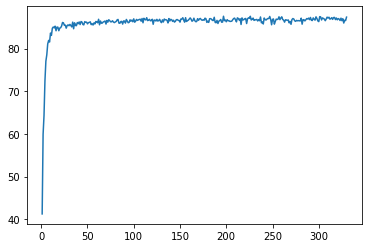

In [9]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {}%\t||test {}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {}%\t||test {}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [10]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()

print("writings done!")
print("Files at: "+grandstore_string)

# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)

writings done!
Files at: grandstore/cifar10_EfficientNetb2_stn120211123153541.pkl
